In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [20]:
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima

In [17]:
df = pd.read_excel('./dataset/bulanan-ekspor-impor.xlsx', parse_dates=[0], index_col=0)
df = df.dropna()
df = df.loc[:,['Nilai-Ekspor']]
df.head()

,Nilai-Ekspor
Bulan-Tahun,
2019-01-01,1.402809e+10
2019-02-01,1.278856e+10
2019-03-01,1.444779e+10
2019-04-01,1.306807e+10
2019-05-01,1.475189e+10


(array([7.50e+09, 1.00e+10, 1.25e+10, 1.50e+10, 1.75e+10, 2.00e+10,
        2.25e+10, 2.50e+10, 2.75e+10, 3.00e+10]),
 [Text(0, 7500000000.0, '0.75'),
  Text(0, 10000000000.0, '1.00'),
  Text(0, 12500000000.0, '1.25'),
  Text(0, 15000000000.0, '1.50'),
  Text(0, 17500000000.0, '1.75'),
  Text(0, 20000000000.0, '2.00'),
  Text(0, 22500000000.0, '2.25'),
  Text(0, 25000000000.0, '2.50'),
  Text(0, 27500000000.0, '2.75'),
  Text(0, 30000000000.0, '3.00')])

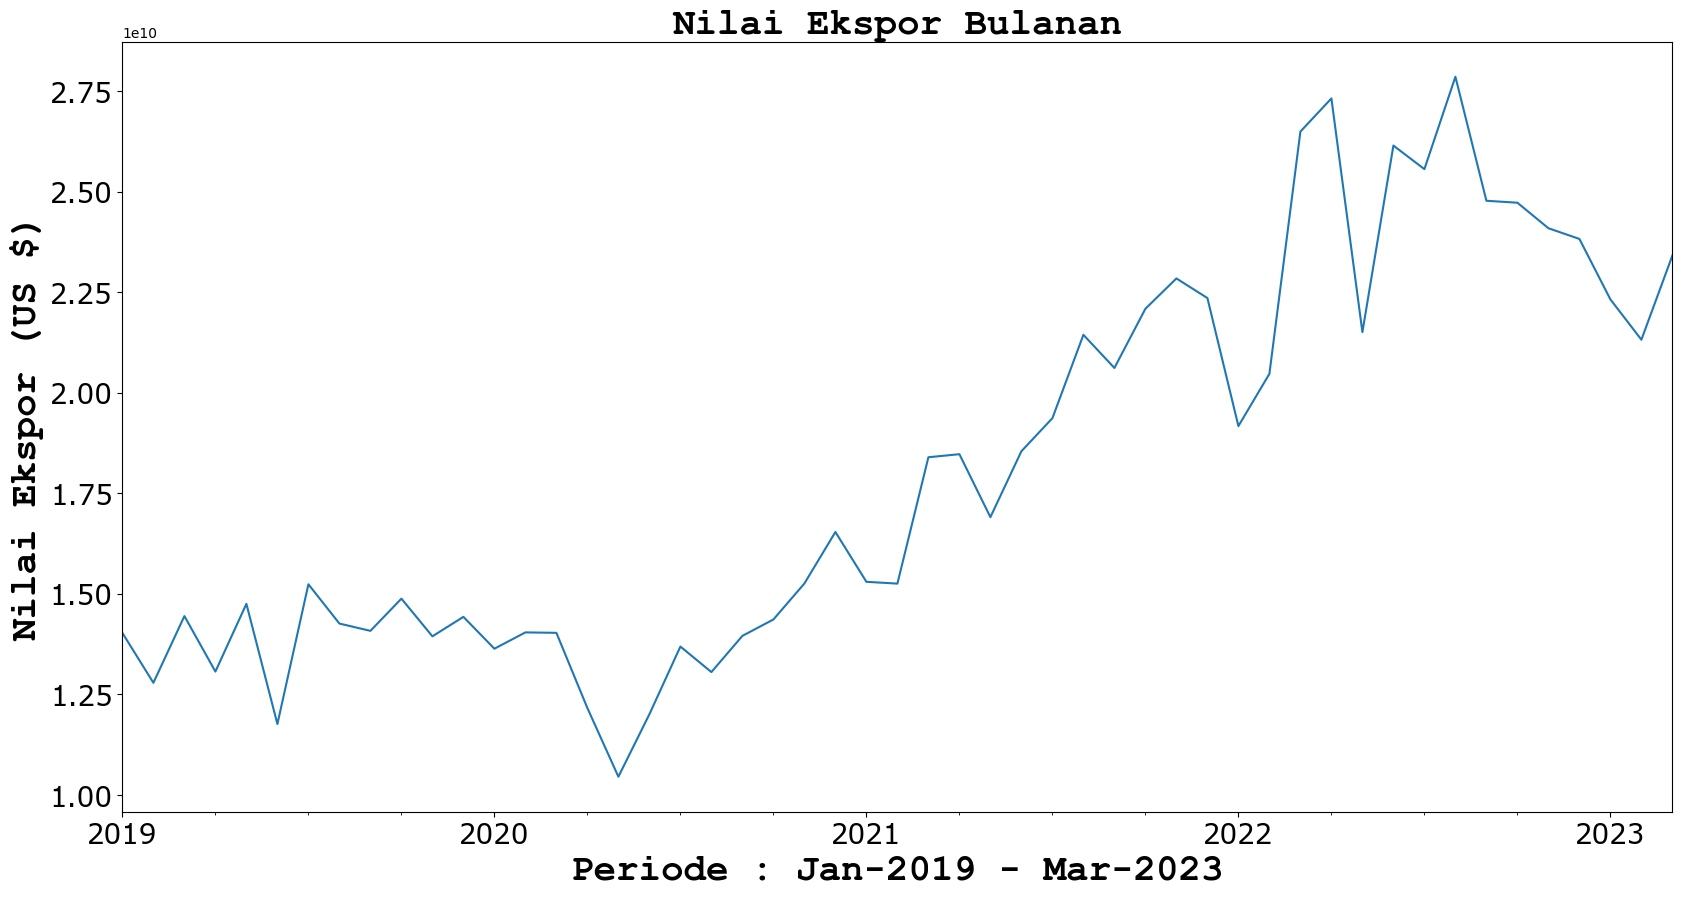

In [23]:
df['Nilai-Ekspor'].plot(figsize=(20,10))
plt.title('Nilai Ekspor Bulanan', fontsize=27, fontname='Courier New', fontweight='bold')
plt.xlabel('Periode : Jan-2019 - Mar-2023', fontsize=27, fontname='Courier New', fontweight='bold')
plt.ylabel('Nilai Ekspor (US $)',fontsize=27, fontname='Courier New', fontweight='bold')
plt.xticks(fontsize=20, fontname='Verdana',)
plt.yticks(fontsize=20, fontname='Verdana',)
# plt.savefig('plot 1')

In [28]:
train = df.loc[df.index < '2022-06-01']

(array([7.50e+09, 1.00e+10, 1.25e+10, 1.50e+10, 1.75e+10, 2.00e+10,
        2.25e+10, 2.50e+10, 2.75e+10, 3.00e+10]),
 [Text(0, 7500000000.0, '0.75'),
  Text(0, 10000000000.0, '1.00'),
  Text(0, 12500000000.0, '1.25'),
  Text(0, 15000000000.0, '1.50'),
  Text(0, 17500000000.0, '1.75'),
  Text(0, 20000000000.0, '2.00'),
  Text(0, 22500000000.0, '2.25'),
  Text(0, 25000000000.0, '2.50'),
  Text(0, 27500000000.0, '2.75'),
  Text(0, 30000000000.0, '3.00')])

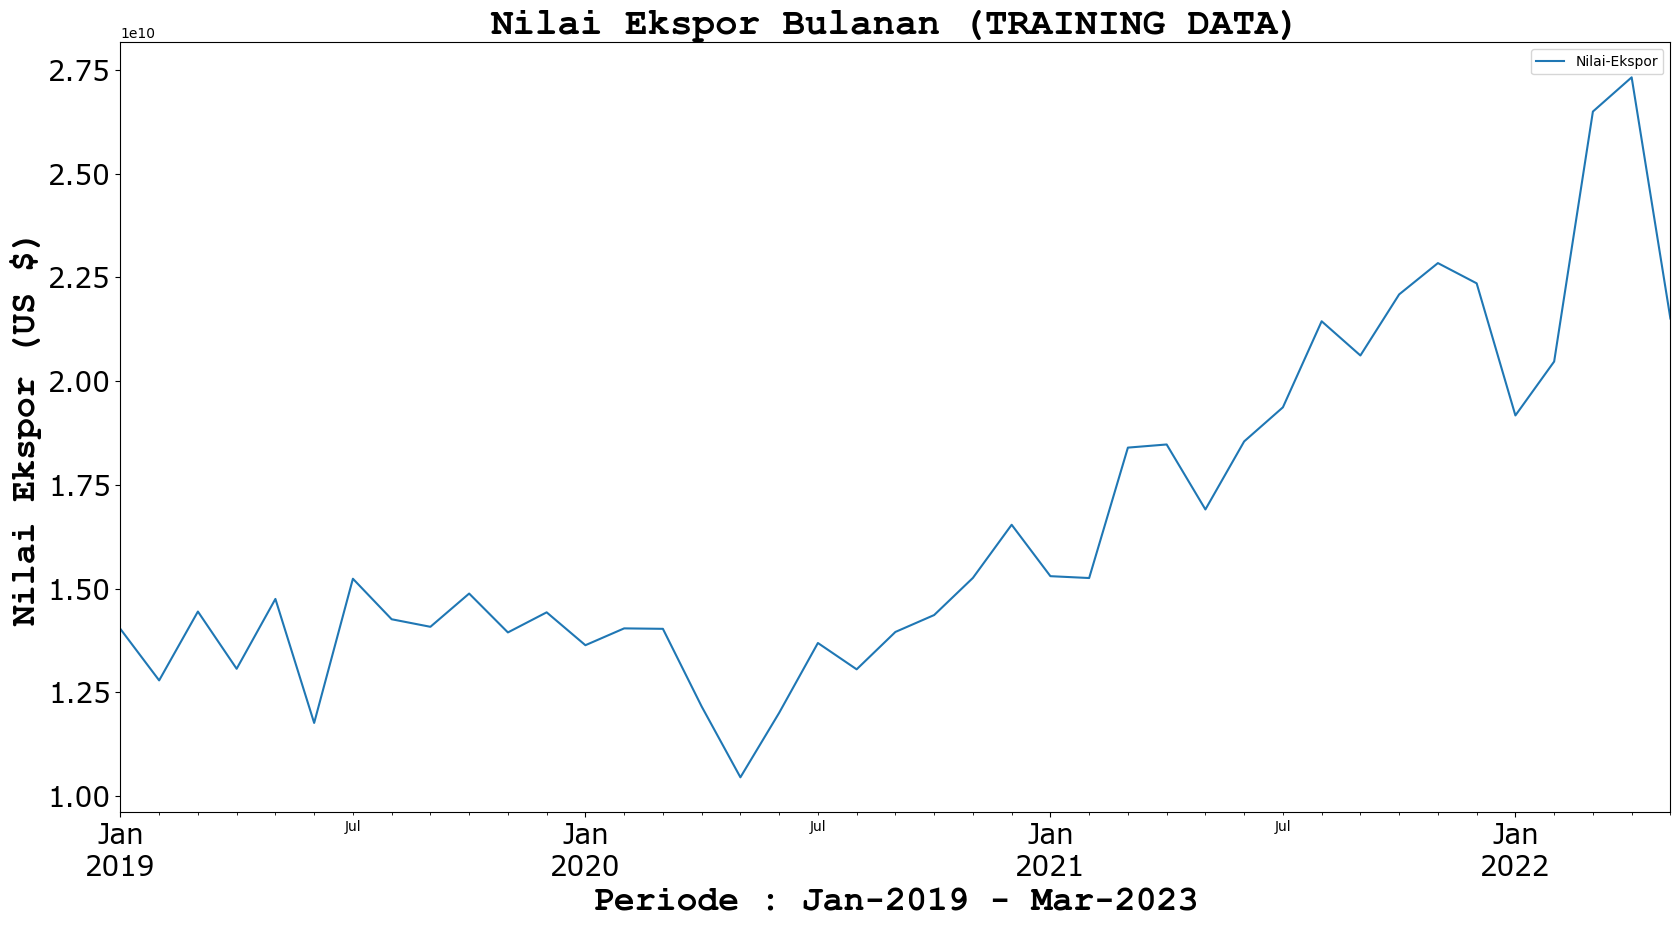

In [29]:
train.plot(figsize=(20,10))
plt.title('Nilai Ekspor Bulanan (TRAINING DATA)', fontsize=27, fontname='Courier New', fontweight='bold')
plt.xlabel('Periode : Jan-2019 - Mar-2023', fontsize=25, fontname='Courier New', fontweight='bold')
plt.ylabel('Nilai Ekspor (US $)',fontsize=25, fontname='Courier New', fontweight='bold')
plt.xticks(fontsize=20, fontname='Verdana',)
plt.yticks(fontsize=20, fontname='Verdana',)

(array([2.0e+10, 2.1e+10, 2.2e+10, 2.3e+10, 2.4e+10, 2.5e+10, 2.6e+10,
        2.7e+10, 2.8e+10, 2.9e+10]),
 [Text(0, 20000000000.0, '2.0'),
  Text(0, 21000000000.0, '2.1'),
  Text(0, 22000000000.0, '2.2'),
  Text(0, 23000000000.0, '2.3'),
  Text(0, 24000000000.0, '2.4'),
  Text(0, 25000000000.0, '2.5'),
  Text(0, 26000000000.0, '2.6'),
  Text(0, 27000000000.0, '2.7'),
  Text(0, 28000000000.0, '2.8'),
  Text(0, 29000000000.0, '2.9')])

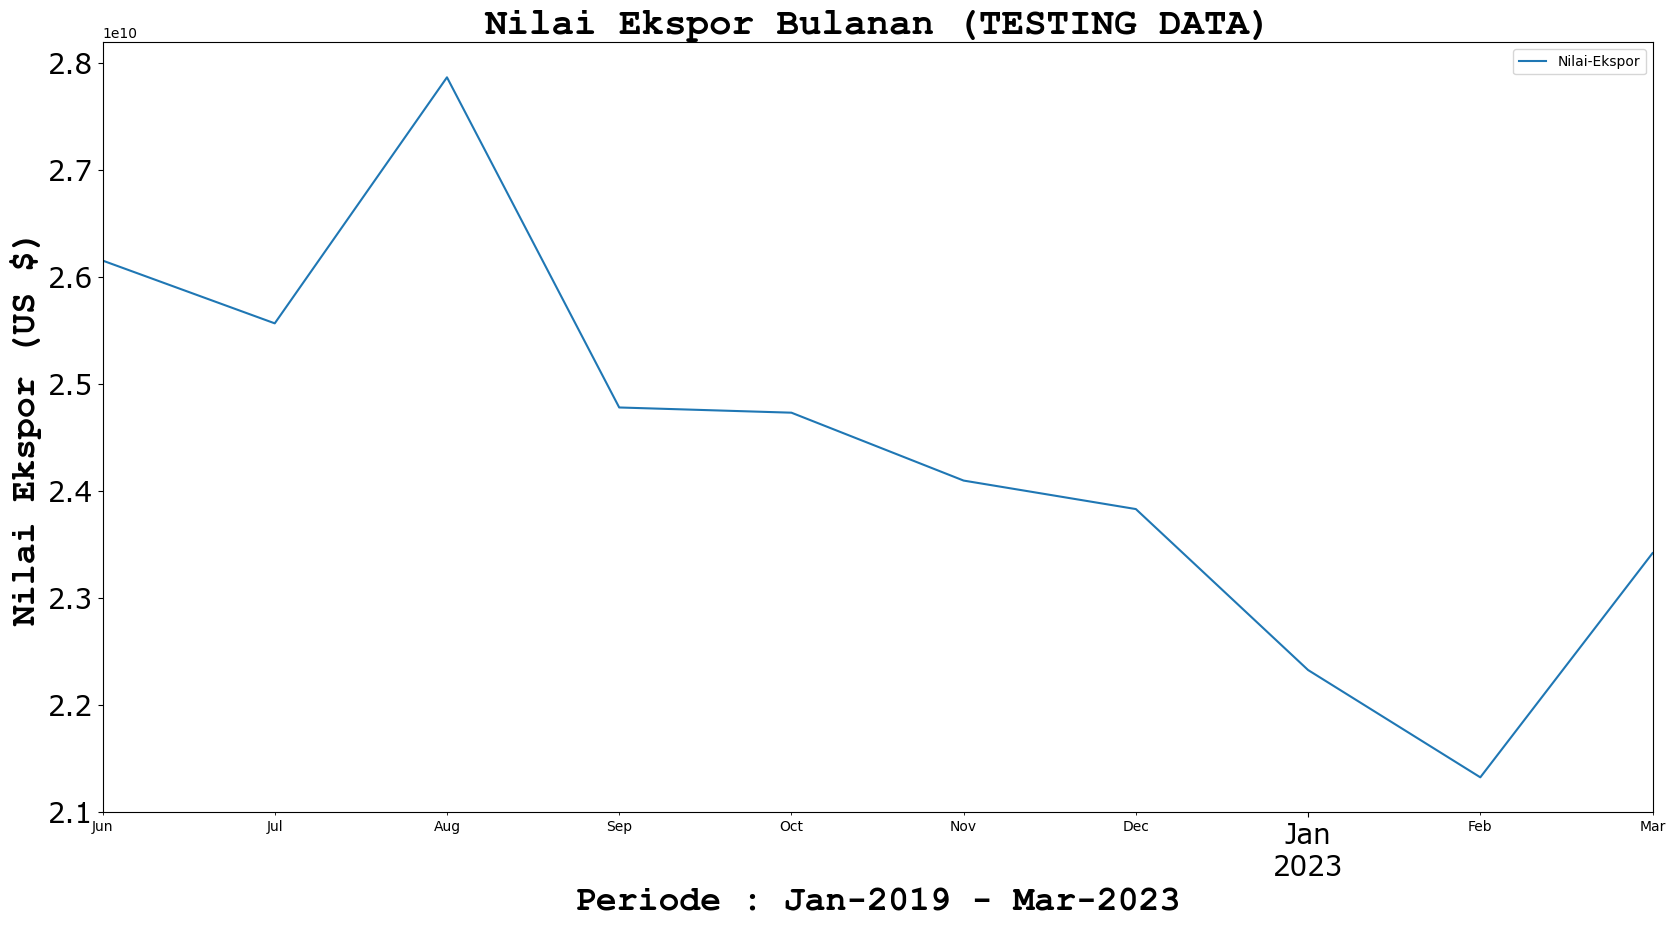

In [40]:
test = df.loc[df.index >= '2022-06-01']

test.plot(figsize=(20,10))
plt.title('Nilai Ekspor Bulanan (TESTING DATA)', fontsize=27, fontname='Courier New', fontweight='bold')
plt.xlabel('Periode : Jan-2019 - Mar-2023', fontsize=25, fontname='Courier New', fontweight='bold')
plt.ylabel('Nilai Ekspor (US $)',fontsize=25, fontname='Courier New', fontweight='bold')
plt.xticks(fontsize=20, fontname='Verdana',)
plt.yticks(fontsize=20, fontname='Verdana',)

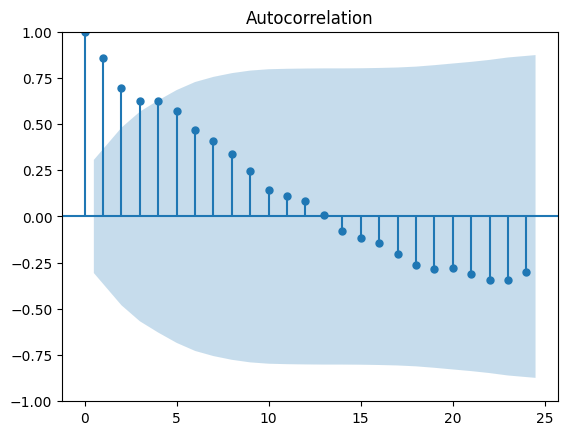

In [31]:
train_acf = plot_acf(train, lags=24)

In [37]:
lr = sm.OLS(endog=train['Nilai-Ekspor'], exog=sm.add_constant(np.arange(1, 1 + train.shape[0]))).fit() 
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:           Nilai-Ekspor   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     79.96
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           5.49e-11
Time:                        00:59:27   Log-Likelihood:                -941.65
No. Observations:                  41   AIC:                             1887.
Df Residuals:                      39   BIC:                             1891.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.073e+10   7.44e+08     14.412      0.0

In [38]:
y_hat = lr.fittedvalues

In [39]:
y_ci = lr.get_prediction().conf_int(alpha=0.05)

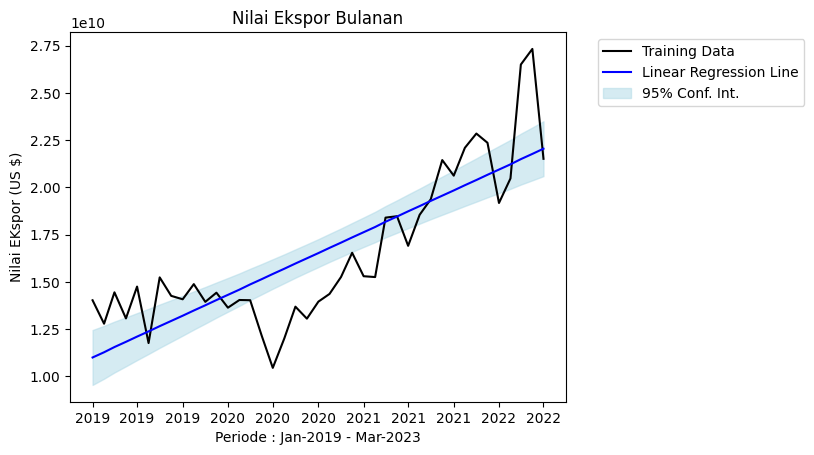

In [42]:
fig, ax = plt.subplots()
plt.xlabel('Periode : Jan-2019 - Mar-2023')
plt.ylabel('Nilai EKspor (US $)')
plt.title('Nilai Ekspor Bulanan')
plt.plot(train, color='black', label='Training Data')
plt.plot(y_hat, color='blue', label='Linear Regression Line')
plt.fill_between(y_hat.index, y_ci[:, 0], y_ci[:, 1], color='lightblue', alpha=0.5, label='95% Conf. Int.')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

In [43]:
auto_arima_model = auto_arima(train, m=12, with_intercept=False, suppress_warnings=True)
print(auto_arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   41
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -637.939
Date:                            Wed, 07 Jun 2023   AIC                           1279.878
Time:                                    01:05:55   BIC                           1282.542
Sample:                                01-01-2019   HQIC                          1280.692
                                     - 05-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1561      0.171     -0.911      0.362      -0.492       0.180
sigma2      3.682e+18   9.19e-21   

In [44]:
auto_arima_model.order

(1, 1, 0)

In [45]:
auto_arima_model.seasonal_order

(0, 1, 0, 12)

In [46]:
resid = auto_arima_model.resid()

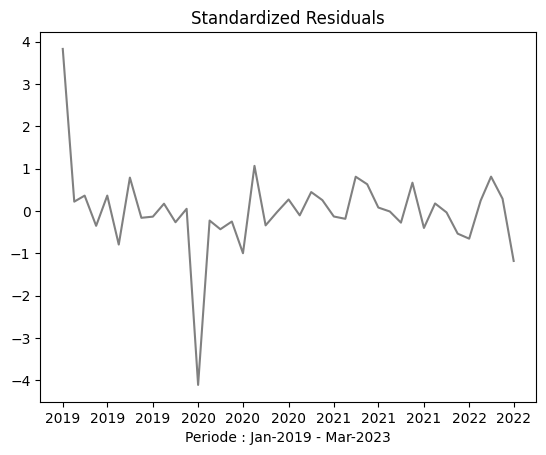

In [48]:
fig, ax = plt.subplots()
plt.plot(train.index, stats.zscore(resid), color='gray')
plt.title('Standardized Residuals')
plt.xlabel('Periode : Jan-2019 - Mar-2023')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

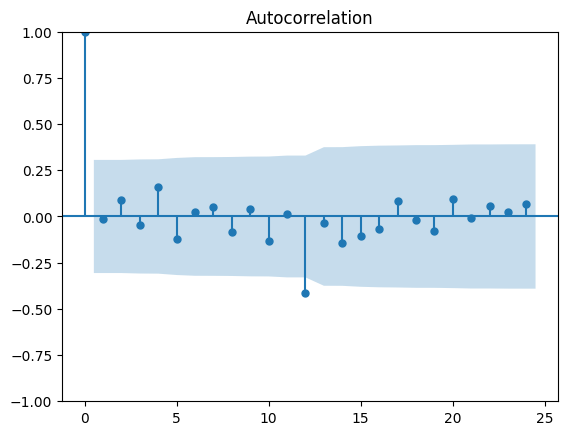

In [49]:
res_acf = plot_acf(resid, lags=24)

In [50]:
res_lb = acorr_ljungbox(resid, lags=24, return_df=False)[1]

KeyError: 1